# DL_comp2_全_report

## Member

- 邱煒甯, 108072244
- 劉祥暉, 109072142
- 簡佩如, 112065525
- 陳凱揚, 108032053

## 1. Data Augmentation (copy and paste)

我們使用了以下兩種方式來做data augmentation，目的除了對原先的照片做基本的random flip, roate和hsv調整外，更重要的是解決class imbalance的問題，像是person的數量遠比其他class的數量多上不少。

### 1.1 Copy and paste

為了解決data imbalance的問題，我們將數量較少的class的object剪下來隨機貼到其他的image上，貼上的方式為不覆蓋到其他box為主，同時也會對貼上的box做random flip, rotate和hsv調整，並檢查其長寬與目標image長寬的比例介於一定範圍中（0.1~0.6)，避免有很小的box貼到很大張的image中，導致之後resize後，box可能會小到無法辨認。

以下圖片是其中幾張copy paste的結果。

In [ ]:
MIN_RATIO_TO_PASTE = 0.1
MAX_RATIO_TO_PASTE = 0.6
RANDOM_FLIP_H = True
RANDOM_FLIP_V = True
RANDOM_ROTATE = True
RANDOM_HSV = True

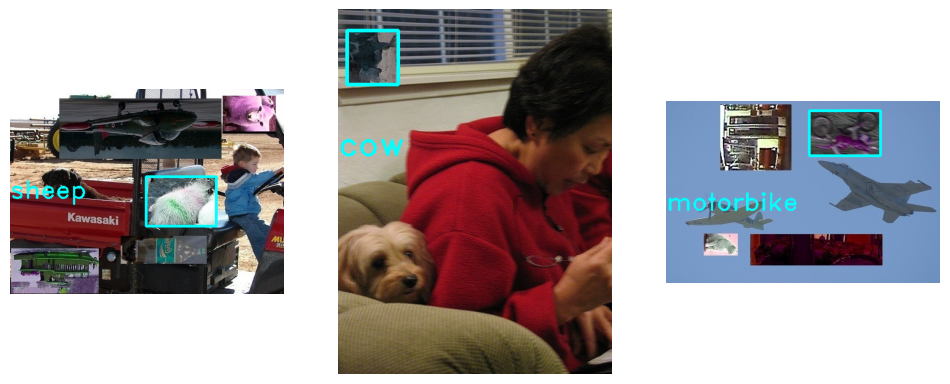

### 1.2 挖空 (使數量較多的class變少)

挖空則是將數量較多的class的box做隨機挖空，直接挖成如下圖空白，並刪除box的label。

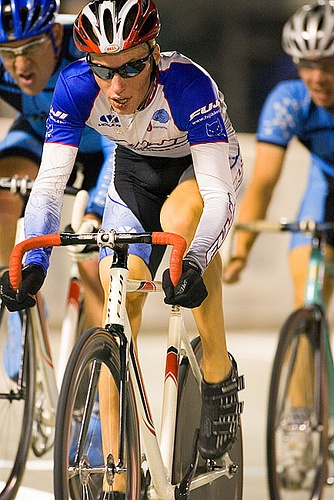

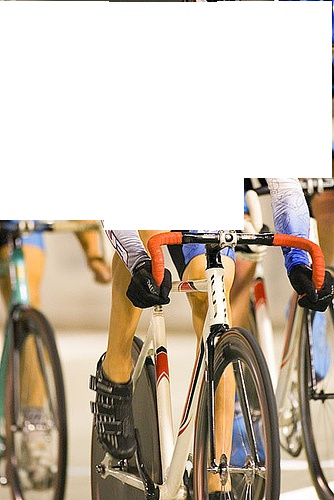

## 2. Ensemble Learning (weighted_boxes_fusion)

我們最終採用的模型是由多個不同變形的YOLO model，再做ensemble後而產生的，ensemble幫助我們從多個model的預測box及其confidence中，進行融合得到更精準的box。

### 2.1 Model

以下為我們ensemble使用的7個model，都是從YOLO做變形而得，像是使用不同的pretrain model (ResNet50, ResNet152, ResNet152V2, MobileNetV2)，並調整後面的layer，採取不同的hyperparameter。相同的是最終輸出的shape都是1470。

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=tf.keras.initializers.TruncatedNormal())(inputs)
    x = layers.LeakyReLU(0.1)(x)

    return x

def resnet_layer():
    resnet = tf.keras.applications.resnet.ResNet152(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    resnet.trainable = False

    return resnet

img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = resnet_layer()(img_inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1470, activation='linear')(x)


YOLO1 = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO1")

YOLO1.summary()

ckpt1 = tf.train.Checkpoint(net=YOLO1)
manager1 = tf.train.CheckpointManager(ckpt1, '/work/u6180060/DL/ckpts/YOLO', max_to_keep=3)
ckpt1.restore(manager1.latest_checkpoint)

Model: "YOLO1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 resnet152 (Functional)      (None, 14, 14, 2048)      58370944  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=tf.keras.initializers.TruncatedNormal())(inputs)
    x = layers.LeakyReLU(0.1)(x)

    return x

def resnet_layer():
    resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    resnet.trainable = False

    return resnet

img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = resnet_layer()(img_inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1470, activation='linear')(x)


YOLO2 = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO2")

YOLO2.summary()

ckpt2 = tf.train.Checkpoint(net=YOLO2)
manager2 = tf.train.CheckpointManager(ckpt2, '/work/u6180060/DL/ckpts/YOLO2', max_to_keep=3)
ckpt2.restore(manager2.latest_checkpoint)

Model: "YOLO2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 14, 14, 2048)      23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 4096)              8392704   
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0         
                                                             

In [ ]:
def EfficientNet_layer():
    EfficientNet = tf.keras.applications.EfficientNetB7(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    EfficientNet.trainable = False

    return EfficientNet

def ResNet_layer():
    ResNet=tf.keras.applications.ResNet152V2(include_top=False, weights='imagenet')
    ResNet.trainable = False

    return ResNet

img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = EfficientNet_layer()(img_inputs)
x = layers.GlobalAvgPool2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1470, activation='linear')(x)


YOLO3 = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO3")

YOLO3.summary()

ckpt3 = tf.train.Checkpoint(net=YOLO3)
manager3 = tf.train.CheckpointManager(ckpt3, '/home/u6180060/DL/chiu/ckpts/YOLO/EN', max_to_keep=3)
ckpt3.restore(manager3.latest_checkpoint)

Model: "YOLO3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 efficientnetb7 (Functional  (None, 14, 14, 2560)      64097687  
 )                                                               
                                                                 
 global_average_pooling2d_2  (None, 2560)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_2 (Flatten)         (None, 2560)              0         
                                                                 
 dense_4 (Dense)             (None, 2048)              5244928   
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0     

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def conv_leaky_relu(inputs, filters, size, stride,dropout_rate=None):
    x = layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=tf.keras.initializers.TruncatedNormal())(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.1)(x)

    if dropout_rate:
        x = layers.Dropout(dropout_rate)(x)

    return x

def ResNet_layer():
    ResNet = tf.keras.applications.ResNet152V2(include_top=False, weights='imagenet')
    ResNet.trainable = False

    return ResNet

img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = ResNet_layer()(img_inputs)
x = conv_leaky_relu(x, 64, 3, 1)
x = conv_leaky_relu(x, 64, 3, 1)
x = conv_leaky_relu(x, 64, 3, 1)
x = conv_leaky_relu(x, 64, 3, 1)
x = conv_leaky_relu(x, 64, 3, 1)
x = conv_leaky_relu(x, 64, 3, 1)
x = layers.Flatten()(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1470, activation='linear')(x)


YOLO4 = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO4")

YOLO4.summary()

ckpt4 = tf.train.Checkpoint(net=YOLO4)
manager4 = tf.train.CheckpointManager(ckpt4, '/home/u6180060/DL/chiu/ckpts/YOLO/Resnet152V2_conv_6', max_to_keep=3)
ckpt4.restore(manager4.latest_checkpoint)

Model: "YOLO4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, None, None, 2048   58331648  
                             )                                   
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        1179712   
                                                                 
 batch_normalization (Batch  (None, 14, 14, 64)        256       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        36928 

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=tf.keras.initializers.TruncatedNormal())(inputs)
    x = layers.LeakyReLU(0.1)(x)

    return x

def resnet_layer():
    resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    resnet.trainable = True

    return resnet

img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = resnet_layer()(img_inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1470, activation='linear')(x)


YOLO5 = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO5")

YOLO5.summary()

ckpt5 = tf.train.Checkpoint(net=YOLO5)
manager5 = tf.train.CheckpointManager(ckpt5, '/work/u6180060/DL/ckpts/YOLO4', max_to_keep=3)
ckpt5.restore(manager5.latest_checkpoint)

Model: "YOLO5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 14, 14, 2048)      23587712  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                             

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2

mobilenet_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
mobilenet_model.trainable = False

img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
mobilenet_output = mobilenet_model(img_inputs)
x = layers.Conv2D(256, 3, padding="same", activation='relu')(mobilenet_output)
x = layers.Conv2D(64, 4, padding="same", activation='relu')(x)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 128, 8, 2)
x = conv_leaky_relu(x, 512, 4, 1)
x = conv_leaky_relu(x, 1024, 2, 1)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1470, activation='linear')(x)


YOLO6 = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO6")

YOLO6.summary()

ckpt6 = tf.train.Checkpoint(net=YOLO6)
manager6 = tf.train.CheckpointManager(ckpt6, '/home/u6180060/DL/chiu/ckpts/YOLO/Mobile_conv_pei', max_to_keep=3)
ckpt6.restore(manager6.latest_checkpoint)

Model: "YOLO6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 448, 448, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 14, 14, 1280)      2257984   
 tional)                                                         
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 256)       2949376   
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        262208    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 128)         524416

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2

mobilenet_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
mobilenet_model.trainable = False

img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
mobilenet_output = mobilenet_model(img_inputs)
x = layers.GlobalAveragePooling2D()(mobilenet_output)
x = layers.Flatten()(x)
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1470, activation='linear')(x)


YOLO7 = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO7")

YOLO7.summary()

ckpt7 = tf.train.Checkpoint(net=YOLO7)
manager7 = tf.train.CheckpointManager(ckpt7, '/home/u6180060/DL/chiu/ckpts/YOLO/Mobile_globalpool', max_to_keep=3)
ckpt7.restore(manager7.latest_checkpoint)

Model: "YOLO7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 448, 448, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 14, 14, 1280)      2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_4  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_6 (Flatten)         (None, 1280)              0         
                                                                 
 dense_12 (Dense)            (None, 2048)              2623488   
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0     

### 2.2 Ensemble

我們ensemble的方式是使用ensemble_boxes這個package中的weighted_boxes_fusion，並調整相關的hyperparameter(IOU_THR, SKIP_BOX_THR, CONF_TYPE)。

In [ ]:
from ensemble_boxes import weighted_boxes_fusion

# ensemble params
IOU_THR = 0.01
SKIP_BOX_THR = 0.001
CONF_TYPE = 'max' # avg, max, box_and_model_avg, absent_model_aware_avg

boxes, scores, labels = weighted_boxes_fusion(
    boxes_list.tolist(),
    scores_list.tolist(),
    labels_list.tolist(),
    weights=weights,
    iou_thr=IOU_THR,
    skip_box_thr=SKIP_BOX_THR,
    conf_type=CONF_TYPE,
)

### 2.3 Predict

以下為隨機幾張我們最終的預測結果，可以看到雖然class大多都能預測正確，但box的位置仍然不夠準確，僅能框到大致上的位置。

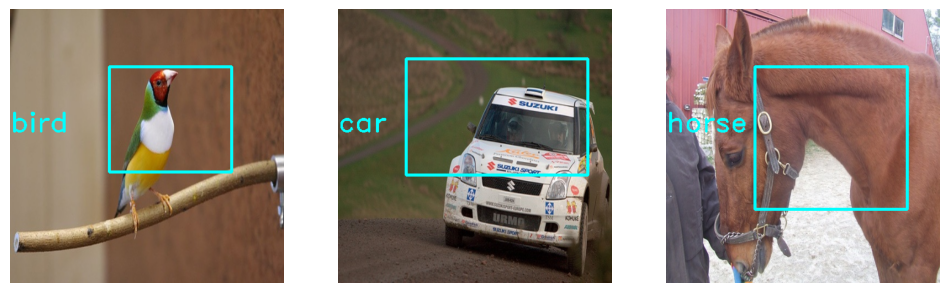

## 3. Conclusion

這次的Competition對於我們來說困難度很大，一開始是處裡class imbalance的問題，我們思考很多解法像是調整YOLO的loss function，但都沒有很好的效果。後來選擇採用Copy-paste搭配挖空的方式將圖片組成，但在過程中又需要時時考慮box的完整性以及重疊的box的問題，因此這部分我們花了不少時間。最後我們也使用其他基本的augmentation技巧才算是增加data多樣性，才算是減輕了data方面的問題。

接下來是model的層面，基本上我們嘗試各種能夠接的pretrain model，但單獨來看他們的效果都不足以達到要求，後來參考weighted box fusion的方式，將各個model ensemble，才達到我們現在的成果，雖然成果可能還是不到非常好，但已經進步許多。

## 4. Reference

- Keras pretrain model: https://keras.io/api/applications/

- Copy-paste: https://arxiv.org/abs/2012.07177

- Ensemble: https://github.com/ZFTurbo/Weighted-Boxes-Fusion/tree/master
